# TODO
1. PairPlots
2. Profiling reports
3. Compare results to preprocessed of UCI

In [221]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
# set pandas to show all columns of the df when using the display function
pd.set_option('display.max_columns', None)

In [222]:
# list the datasets that should be used in the current run
datasets = ["hungarian", "cleveland", "switzerland", "long-beach-va"]

In [223]:
# custom function to read the dataset into a csv formated string
# the name is used as a delimiter here because it is the last feature and common among all entrys
def readRawData(filePath:str):
    with open(filePath) as file:
        dataString = file.read()
        dataString = dataString.replace("\n"," ")
        dataString = re.sub("[a-zA-Z]+ ","name\n", dataString)
        dataString = dataString.replace(" ",",")
        return dataString

In [224]:
# read the data from the specified datasets into the df
from io import StringIO
df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(StringIO(readRawData("./Data/"+ dataset +".data")), header=None, sep=",")
    dataset_df['dataset'] = dataset
    df = pd.concat([df,dataset_df ], ignore_index=True)

In [225]:
df.columns=["id", "ccf", "age", "sex", "painloc", "painexer" , "relrest" , "pncaden" , "cp", "trestbps", "htn", "chol", "smoke", "cigs", "years", "fbs", "dm", "famhist", "restecg", "ekgmo", "ekgday", "ekgyr", "dig", "prop", "nitr", "pro", "diuretic", "proto", "thaldur", "thaltime", "met", "thalach", "thalrest", "tpeakbps", "tpeakbpd", "dummy", "trestbpd", "exang", "xhypo", "oldpeak", "slope", "rldv5", "rldv5e", "ca", "restckm", "exerckm", "restef", "restwm", "exeref", "exerwm", "thal", "thalsev", "thalpul", "earlobe", "cmo", "cday", "cyr", "num", "lmt", "ladprox", "laddist", "diag", "cxmain", "ramus", "om1", "om2", "rcaprox", "rcadist", "lvx1", "lvx2", "lvx3", "lvx4", "lvf", "cathef", "junk", "name", "dataset"]

In [226]:
# read the data from the specified datasets into the df
from io import StringIO
dfNew = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(StringIO(readRawData("./Data/"+ 'new' +".data")), header=None, sep=",")
    dataset_df['dataset'] = dataset
    dfNew = pd.concat([dfNew,dataset_df ], ignore_index=True)

In [227]:
df = df.replace(-9, float('nan'))

In [228]:
irrelevant_columns = [
    "id", # A id is not relevant for a model
    "ccf", # the social security number does not influence if you have a heart disease or not
    "pncaden", # sum of painlox painexer relrest -> the features are already in the dataset -> drop because it is a duplicate
    "ekgmo", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "ekgday", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "ekgyr", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cmo", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cday", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "cyr", # The date of the medical examination is irrelevant for the occurrence of a disease.
    "name", # Constant

]
df.drop(irrelevant_columns, inplace=True, axis=1)

In [229]:
unexplained_columns = [
    "restckm", # irrelevant according to the uci
    "exerckm", # irrelevant according to the uci
    "thalsev", # irrelevant according to the uci
    "thalpul", # irrelevant according to the uci
    "earlobe", # Constant
    "lvx1", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx2", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx3", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvx4", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "lvf", # it is not possible to gain information about what this feature measures -> could not be supplied to trained models -> drop https://archive.ics.uci.edu/ml/datasets/Heart+Disease
    "dummy", # no description available -> from the name does not seem relevant
    'junk'
]
df.drop(unexplained_columns, inplace=True, axis=1)

In [230]:
hidden_identifier = [
    'lmt',      # Left main truck
    'ladprox',  # Proximal left anterior descending artery
    'laddist',  # Distal left anterior descending artery
    'diag',     # Diagonal branches
    'cxmain',   # Circumflex
    'ramus',    # Ramus intermedius
    'om1',      # First obtuse marginal branch
    'om2',      # Second obtuse marginal branch
    'rcaprox',  # Proximal right coronary artery
    'rcadist',  # Distal right coronary artery
]
df.drop(hidden_identifier, inplace=True, axis=1)

# Start of analysis
## Explore how many NaNs and zeros are within one column for each attribute.

In [231]:
(df.loc[:, df.columns != 'dataset'].eq(0)).join(df['dataset']).groupby("dataset").sum()

,age,sex,painloc,painexer,relrest,cp,trestbps,htn,chol,smoke,cigs,years,fbs,dm,famhist,restecg,dig,prop,nitr,pro,diuretic,proto,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restef,restwm,exeref,exerwm,thal,num,cathef
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cleveland,0,91,0,0,0,0,0,108,0,0,115,115,240,0,107,138,271,186,211,252,248,0,0,43,0,0,0,0,0,0,190,276,91,0,0,0,166,0,0,0,0,0,157,0
hungarian,0,81,23,164,141,0,0,195,0,10,0,0,266,0,1,235,293,274,265,269,290,0,0,0,0,0,0,0,0,0,204,291,189,0,0,0,3,0,3,0,2,0,188,0
long-beach-va,0,6,15,65,33,0,1,90,49,96,38,38,125,4,100,80,122,88,61,105,94,0,0,2,0,0,0,0,0,1,52,139,40,1,0,0,2,0,10,0,2,0,51,0
switzerland,0,10,11,22,27,0,0,60,123,5,0,0,43,0,0,85,116,70,75,66,93,0,0,25,0,0,0,0,0,0,68,113,42,0,0,0,0,0,0,0,0,0,8,0


In [232]:
(df.loc[:, df.columns != 'dataset'].eq(-9)).join(df['dataset']).groupby("dataset").sum()

,age,sex,painloc,painexer,relrest,cp,trestbps,htn,chol,smoke,cigs,years,fbs,dm,famhist,restecg,dig,prop,nitr,pro,diuretic,proto,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restef,restwm,exeref,exerwm,thal,num,cathef
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cleveland,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
hungarian,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
long-beach-va,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
switzerland,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## outliers

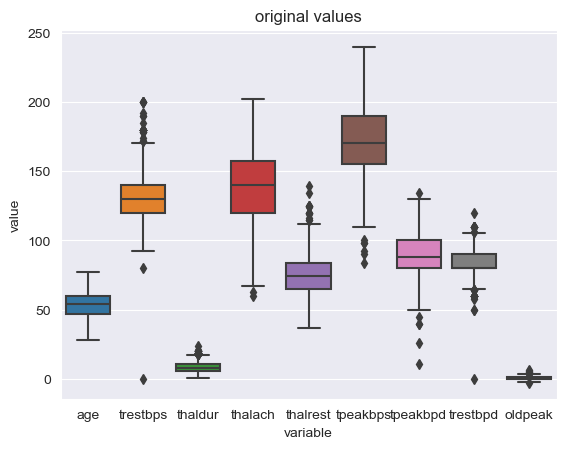

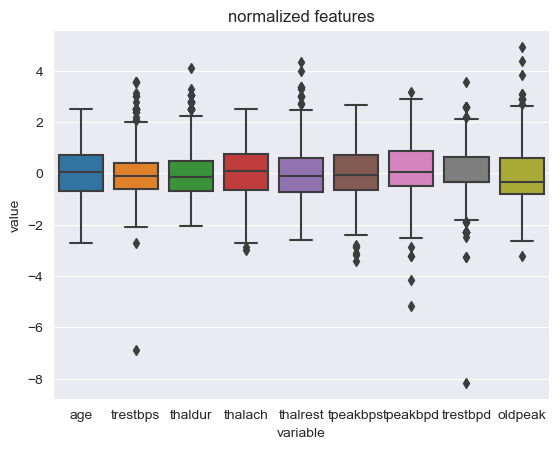

In [233]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

df_continous = df[["age","trestbps","thaldur","thalach","thalrest","tpeakbps","tpeakbpd","trestbpd","oldpeak"]]

sns.boxplot(x="variable", y="value", data=pd.melt(df_continous))
plt.title("original values")
plt.show()

sc = StandardScaler()
temp = sc.fit_transform(df_continous)
df_continous = pd.DataFrame(temp, columns = ["age","trestbps","thaldur","thalach","thalrest","tpeakbps","tpeakbpd","trestbpd","oldpeak"])
sns.boxplot(x="variable", y="value", data=pd.melt(df_continous))
plt.title("normalized features")
plt.show()


## Correlation

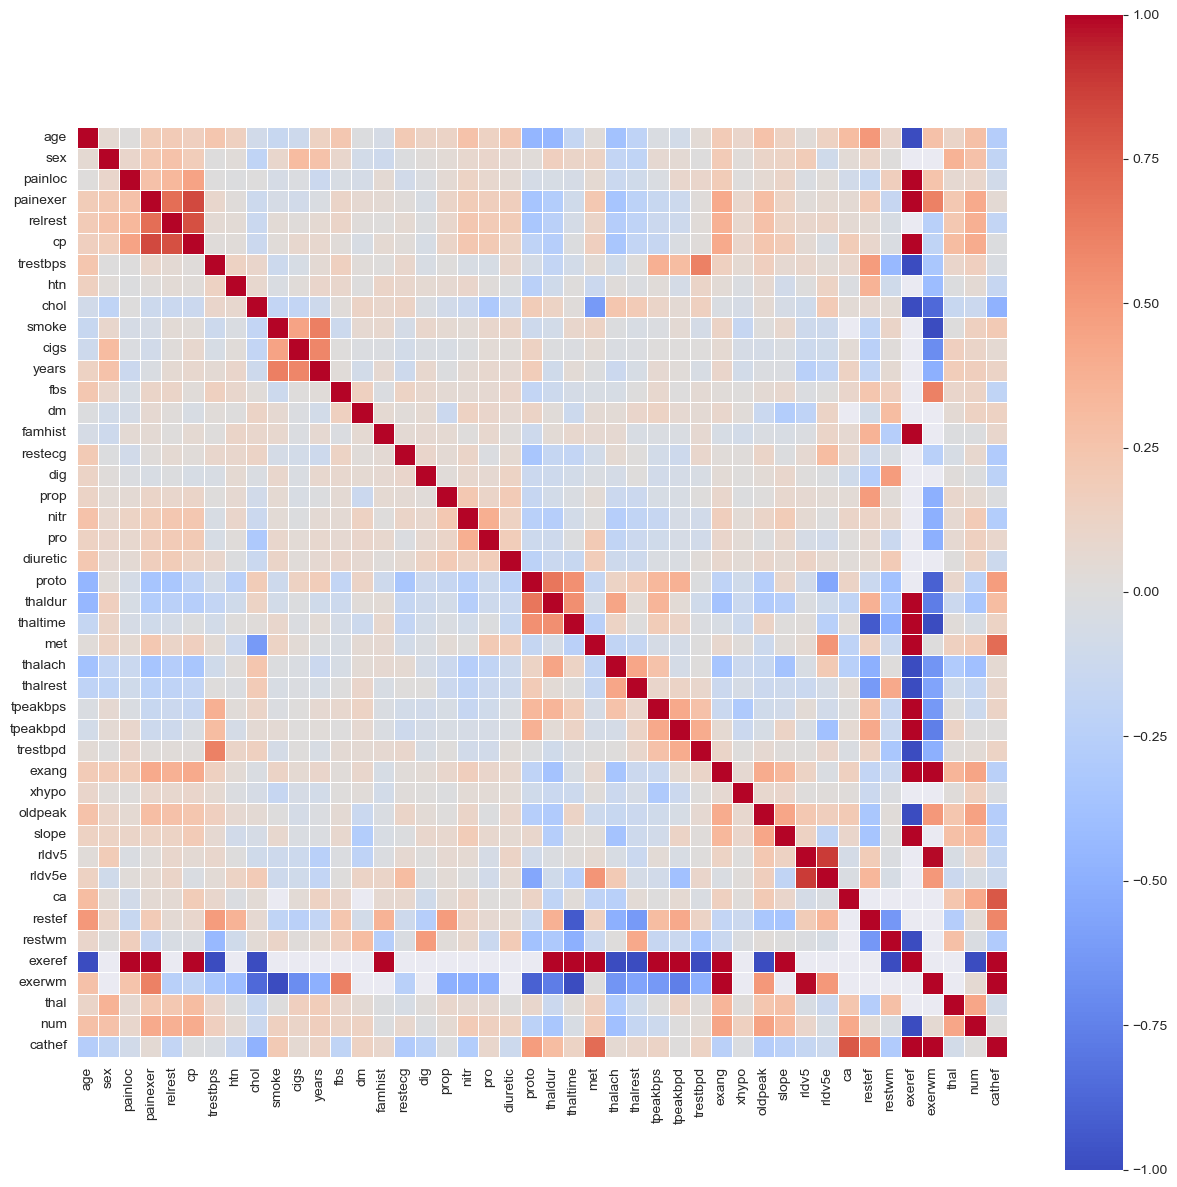

In [234]:
plt.figure(figsize=(15,15))
# Compute the correlation matrix
corr = df.corr()
corr = corr.round(2)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

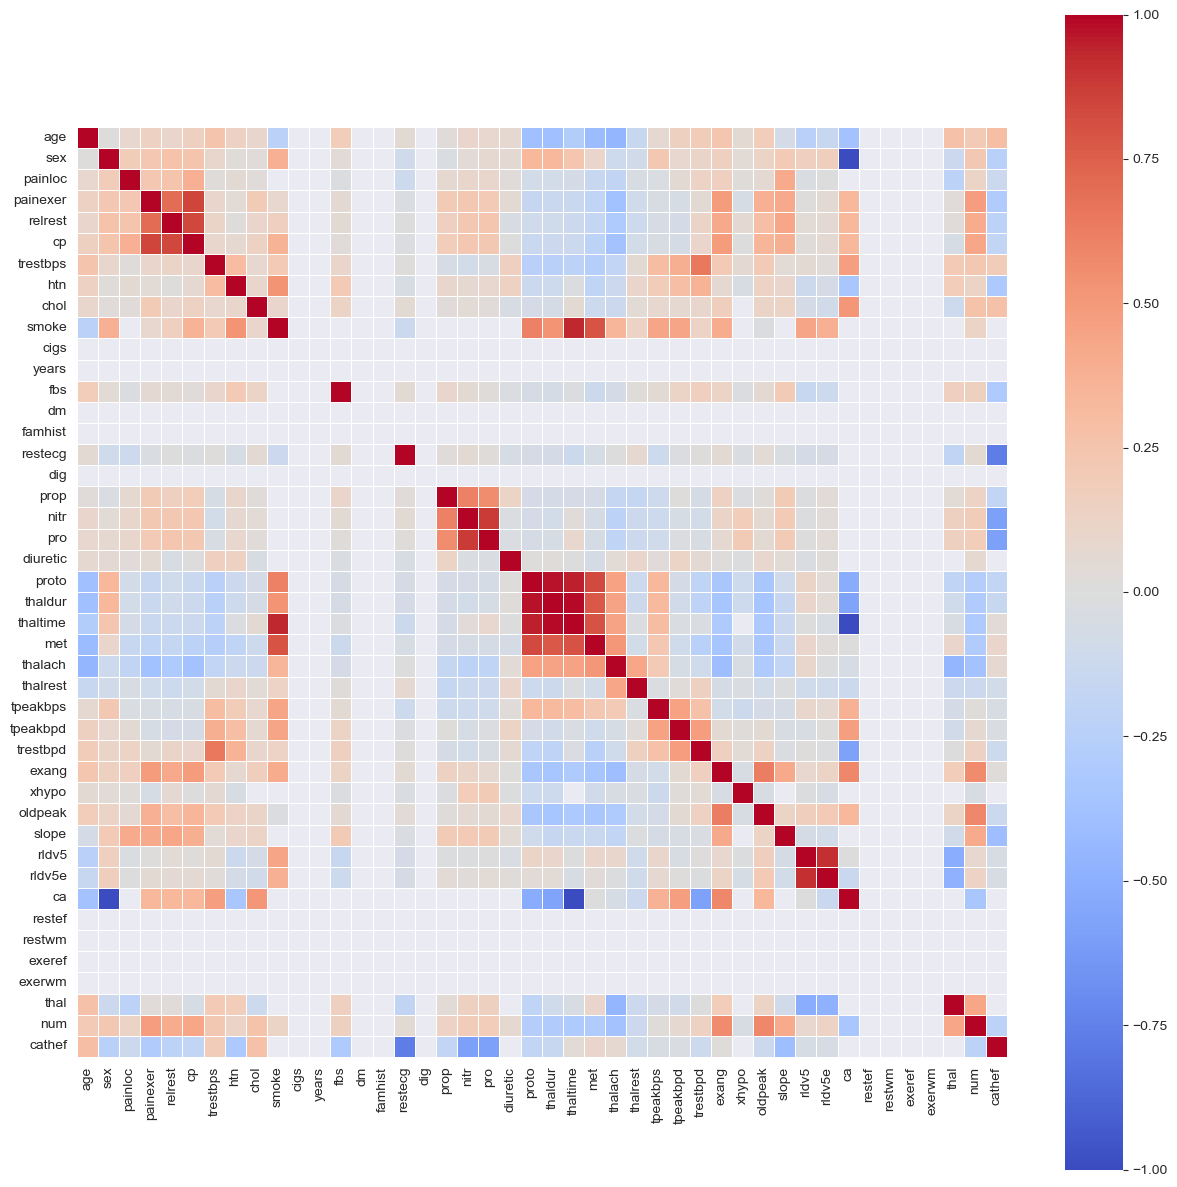

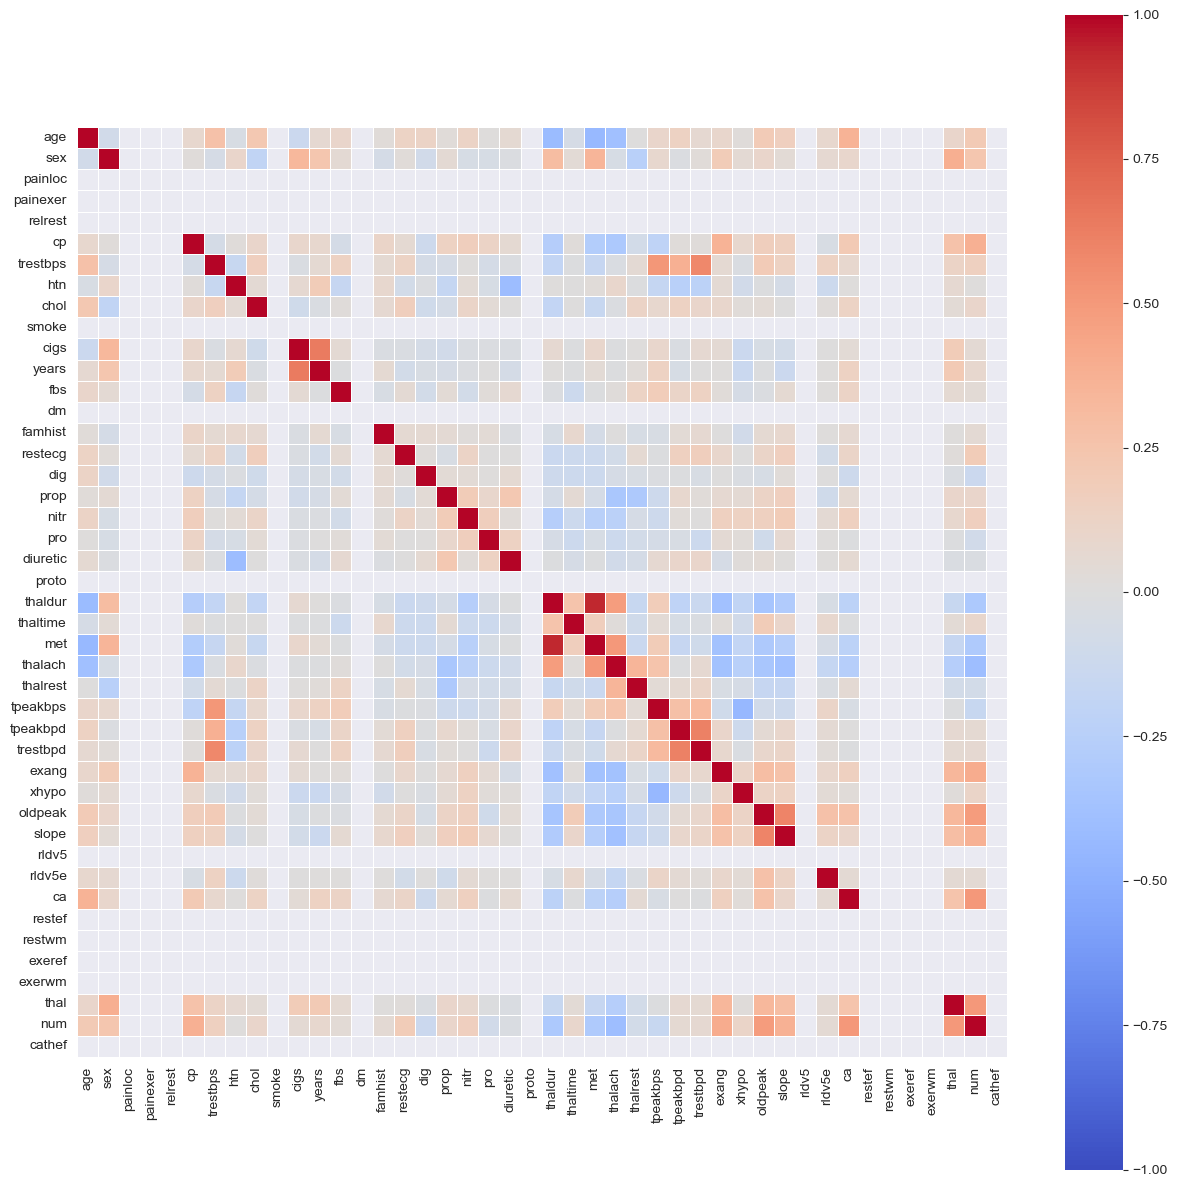

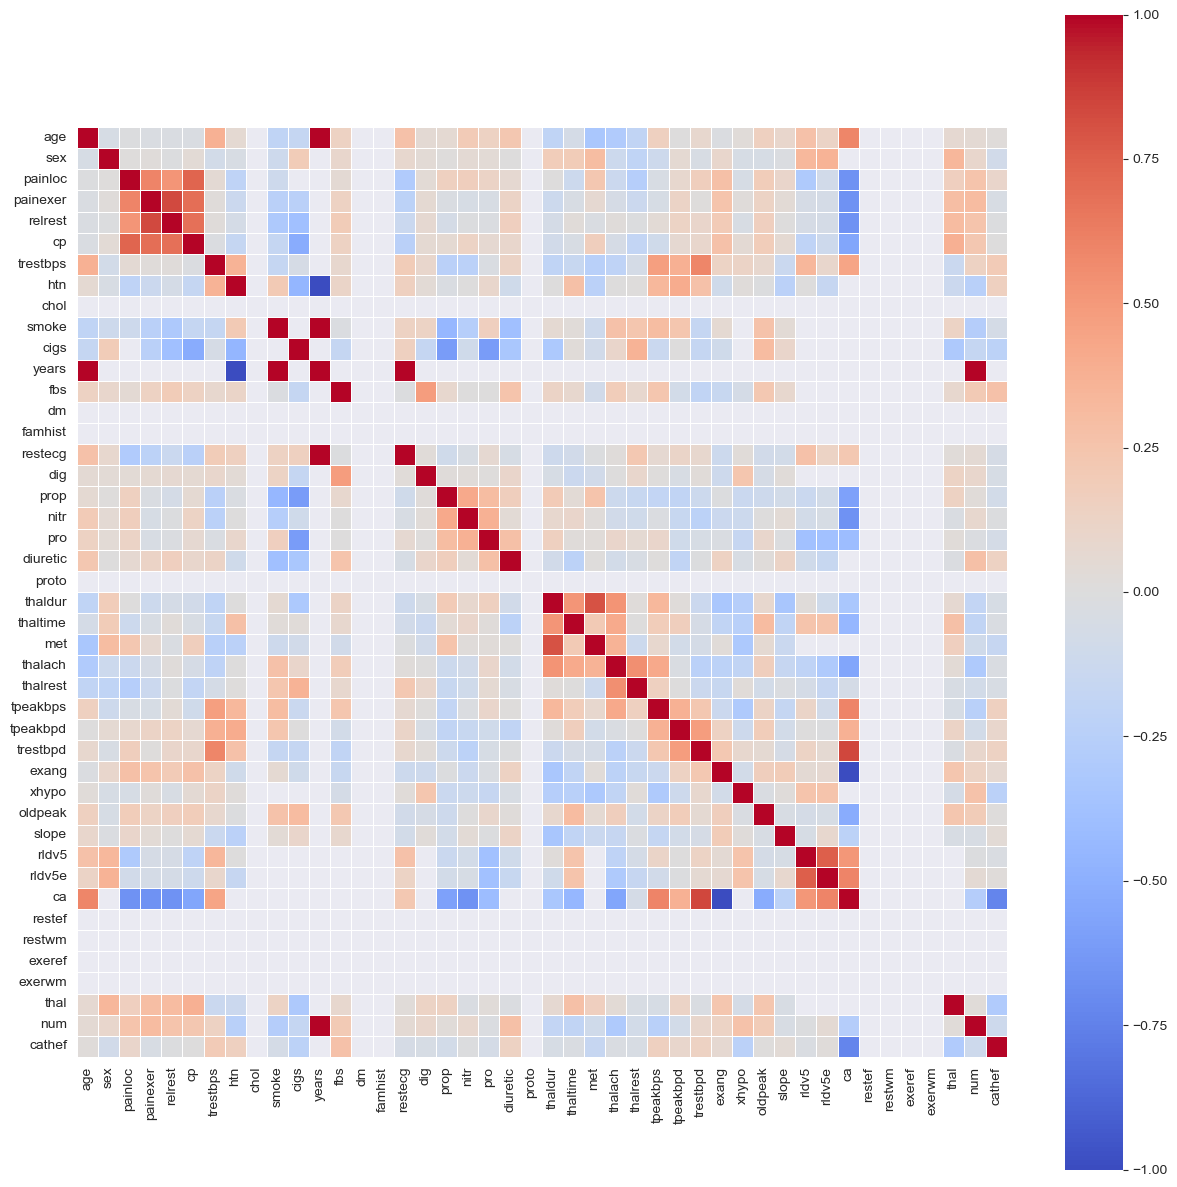

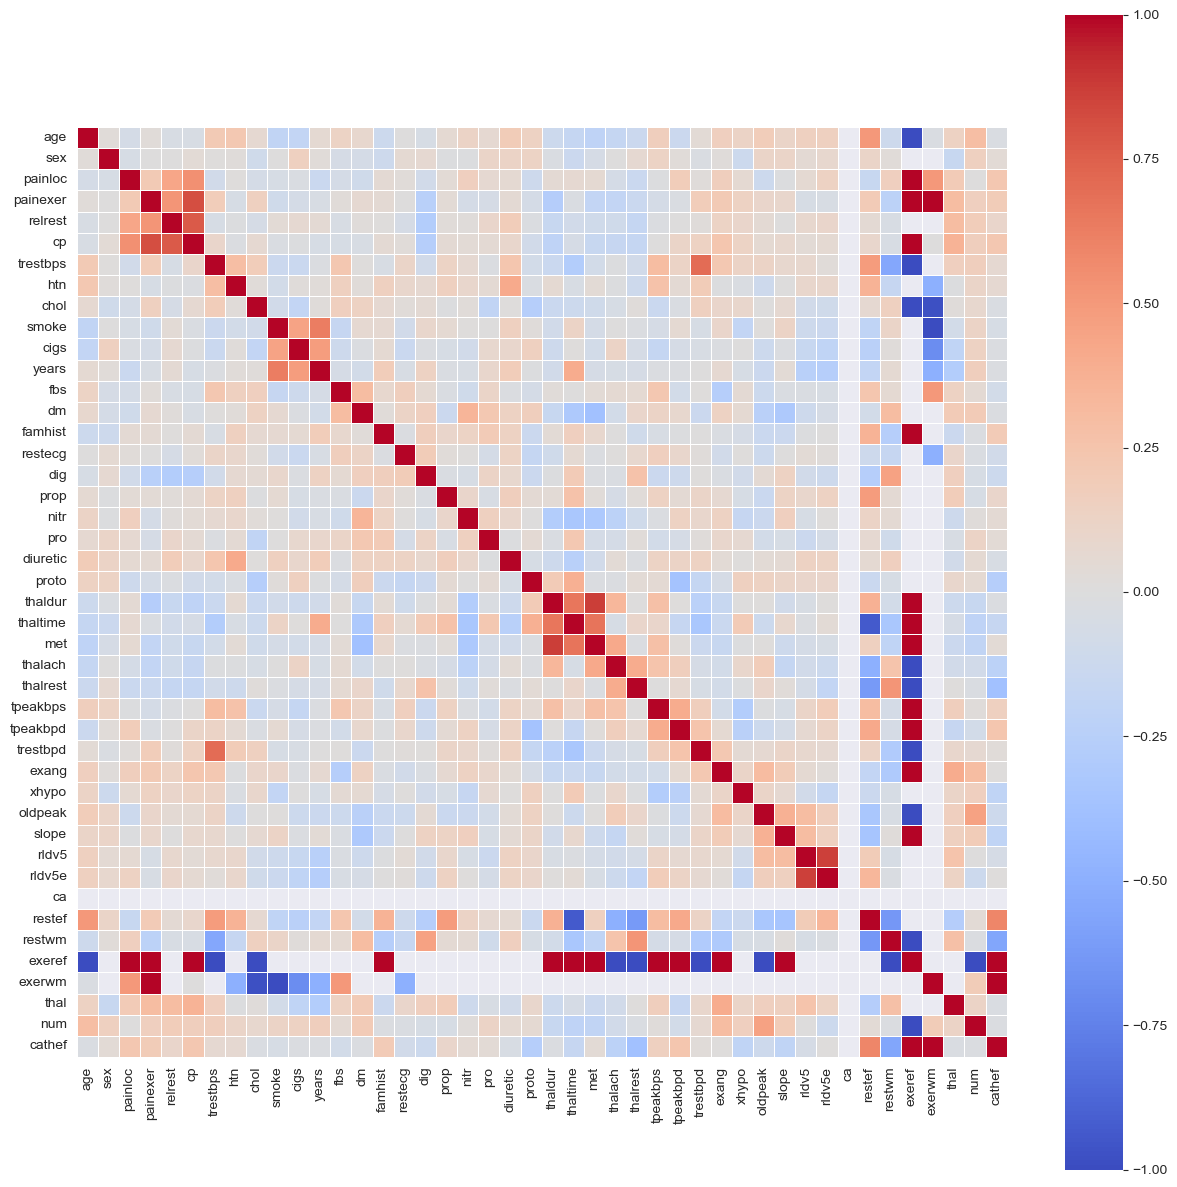

In [235]:
for dataset in datasets:
    plt.figure(figsize=(15, 15))
    # Compute the correlation matrix
    corr = df[df['dataset'] == dataset].corr()
    corr = corr.round(2)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=.5, vmin=-1, vmax=1)
    plt.show()


In [236]:
percentage_missing = ((df.isna().sum()/len(df)*100).round(2)).to_dict()

In [261]:
unstacked_corr = df.corr().unstack().abs()
#index = pd.MultiIndex.from_tuples(tuples)
unstacked_corr = unstacked_corr.reset_index()
unstacked_corr.columns = ["feature1","feature2","correlation"]
unstacked_corr = unstacked_corr[unstacked_corr['feature1'] != unstacked_corr['feature2']]
unstacked_corr['NaN_Values_feature1'] = [percentage_missing[x] for x in unstacked_corr['feature1']]
unstacked_corr['NaN_Values_feature2'] = [percentage_missing[x] for x in unstacked_corr['feature2']]
unstacked_corr[(unstacked_corr["correlation"] > 0.5) & (unstacked_corr['NaN_Values_feature1'] < 50) & (unstacked_corr['NaN_Values_feature2'] < 50)].sort_values(by="correlation", ascending=False)

,feature1,feature2,correlation,NaN_Values_feature1,NaN_Values_feature2
1574,rldv5e,rldv5,0.884520,15.80,47.27
1531,rldv5,rldv5e,0.884520,47.27,15.80
137,painexer,cp,0.834903,31.37,0.00
223,cp,painexer,0.834903,0.00,31.37
181,relrest,cp,0.810914,31.81,0.00
224,cp,relrest,0.810914,0.00,31.81
136,painexer,relrest,0.694375,31.37,31.81
179,relrest,painexer,0.694375,31.81,31.37
989,thaldur,proto,0.663422,6.23,12.46
946,proto,thaldur,0.663422,12.46,6.23


## PairPlots

In [238]:
print_pair_plots = False #was missing
if print_pair_plots:
    sns.pairplot(df, hue="num", palette="tab10")
if print_pair_plots:
    sns.pairplot(df, hue="dataset", palette="tab10")

# minimumPercentageToBeDropped

In [239]:
percentage_missing = ((df.isna().sum()/len(df)*100).round(2)).to_dict()
test = {}
for percentage in np.arange(0,100,1):
    missing_vlaues = {key: val for key, val in percentage_missing.items() if val > percentage}
    test[percentage] = df.drop([*missing_vlaues.keys()], axis=1).shape + (df.drop([*missing_vlaues.keys()], axis=1).isna().sum().sum(), )

In [240]:
test = pd.DataFrame.from_dict(test).transpose()
test.columns = ["rows", "columns", "number of imputed cells"]

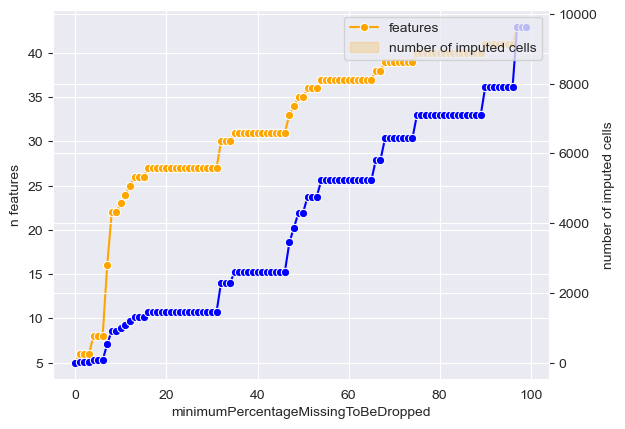

In [241]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1 = sns.lineplot(data=test, y="columns", x=test.index, ax=ax1, color="orange", marker='o')
ax2 = sns.lineplot(data=test, y="number of imputed cells", x=test.index, ax=ax2, color="blue", marker='o')
ax1.set_ylabel('n features')
ax1.set_xlabel('minimumPercentageMissingToBeDropped')
ax2.set_ylabel('number of imputed cells')
ax1.figure.legend(['features','number of imputed cells'], bbox_to_anchor=(1.,1),loc=1, bbox_transform=ax1.transAxes)
plt.show()

In [242]:
percentage_missing = ((df.isna().sum() / len(df) * 100).round(2)).to_dict()
test = {}
for percentage in np.arange(0, 100, 10):
    missing_vlaues = {key: val for key, val in percentage_missing.items() if val > percentage}
    test[percentage] = df.drop([*missing_vlaues.keys()], axis=1).dropna(axis=0, how='any').shape
test = pd.DataFrame.from_dict(test).transpose()
test.columns = ["rows", "columns"]

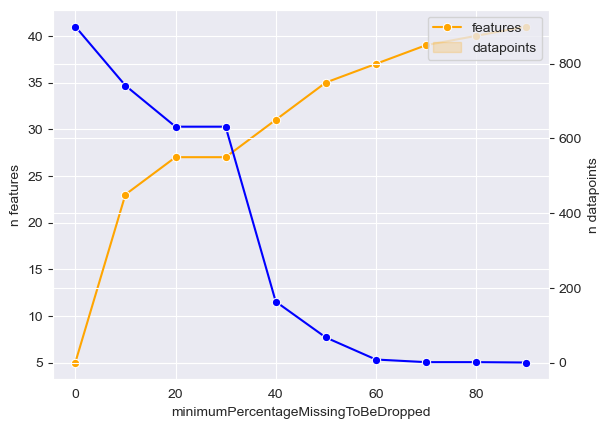

In [243]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1 = sns.lineplot(data=test, y="columns", x=test.index, ax=ax1, color="orange", marker='o')
ax2 = sns.lineplot(data=test, y="rows", x=test.index, ax=ax2, color="blue", marker='o')
ax1.set_ylabel('n features')
ax1.set_xlabel('minimumPercentageMissingToBeDropped')
ax2.set_ylabel('n datapoints')
ax1.figure.legend(['features','datapoints'], bbox_to_anchor=(1.,1),loc=1, bbox_transform=ax1.transAxes)
plt.show()